<a href="https://colab.research.google.com/github/farihast/be5210_finalproject/blob/viraj/viraj_sampat_Final_Project_Part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BE 521: Final Project Part 1
Spring 2022

Adapted by Kevin Xie

32 Points

Objective: Predict finger movements from ECoG Recordings

Due: March 31st


# Project Overview

This final project involves predicting finger flexion using intracranial EEG (ECoG) in three human subjects. The data and problem framing come from the 4th BCI Competition (Miller et al. 2008). For the details of the problem, experimental protocol, data, and evaluation, please see the original 4th BCI Competition documentation (included as separate document). The remainder of the current document details your deliverables for part 1 of the project.


## Important Deadlines
* Final Project Part 1
 * Due: March 31st
 * 32 Points
* Team Registration
 * Due: March 31st
 * 5 Points
* Checkpoint 1
 * Due: April 14th
 * 20 Points
* Checkpoint 2
 * Due: April 21st
 * 15 Points
* End of competition, submit algorithm (Canvas): 
 * Due: April 25th
 * 15 Points
* Final Report
 * Due: April 28th
 * 60 Points
* Competition results (Final class session)
 * On: April 27th

The grading is structured so that going the extra mile is definitely rewarded. We want you to show what you've learned this semester, and to have some fun!

## Writing Your Code
To get started with the final project we have provided a a series of method stubs for you to fill out. Your job for part 1 of the final project is to build a prediction pipeline that takes in the ECoG and dataglove finger angle recordings (serving as the data and labels respectively), then uses machine learning methods to generate predicted finger angles from the ECoG signals. The functions you will develop in this assignment are as follows:
* `get_windowed_feats` This function will take in raw ECoG data, and use the 2 following helper functions to filter the data, calculate sliding-window features. 
 * `filter_data` This function will apply a filter to the raw data and return cleaned data
 * `get_features` This function will take in a window of cleaned data and return a vector of features for that window
* `create_R_matrix` This function will take in a feature matrix and return a response matrix as an adaptation of the optimal linear decoder method. 



## Optimal Linear Decoder
You will use the **optimal linear decoder** method as described in Warland et al., 1997. We will recapitulate the method in this section, but consult the paper for more details. Our ultimate goal is to predict the angle of each finger as it moves over time using data recorded from the ECoG channels. 

The position data is captured for 300 seconds, which you will split up into *M* total time bins, and the number of ECoG channels, *ν*, is 61, 46, and 64 for subject 1, 2, and 3 respectively. 

The paradigm we adapt here tries to predict finger angle at a given time window using ECoG features calculated over the preceding *N* time windows, using
the following steps: 

First, features will be calculated across all *ν* ECoG channels $\times$ *M* total time windows.

Then, following the approach that Warland et al., 1997 takes, we will construct a row vector corresponding to each time bin, that contains features for all the ECoG channels over the preceding *N* time bins (in the paper, spike counts are their features and they index neurons instead of ECoG channels). Thus, there will be a good amount of redundancy between row vectors of adjacent time bins, but that is okay.

Let $r_i^j$ be the value of the feature channel $j$ in time bin $i$. Let the response matrix **R** be defined as (copied from Warland et al. 1997):

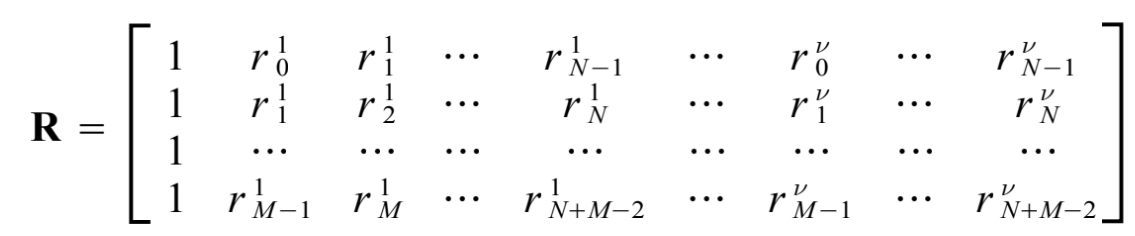




This is also referred to as the design or feature matrix, with each column being a predictor, or feature. The column of 1’s accounts for the intercept term in linear regression/decoding. Make sure you understand what this matrix means before moving on. 

We denote the target matrix (e.g. the $\textbf{M} \times 5$ matrix of finger angles) as the $\textbf{Y}$ and the reconstruction (e.g. the predicted finger angles) as $\hat{\textbf{Y}}$. Note that in Warland et al., 1997, this quantity is referred to as the stimulus vector since they are talking about decoding the stimulus from neural data after it. We, on the other hand, are trying to decode finger positions using the ECoG data before it, but we can conveniently use the same method.

Solving the minimum least-squares difference between the stimulus and reconstruction, $(\textbf{Y} - \hat{\textbf{Y}})^\text{T}(\textbf{Y} - ̂\hat{\textbf{Y}})$, we get the analytic form for the optimal filter, $$ \text{f} = (\textbf{R}^\text{T}\textbf{R})^{-1}(\textbf{R}^\text{T}\textbf{Y})$$

This equation should take a familiar form. Warland et al., 1997 don’t refer to it as such, but this is exactly the same as linear regression, one of the most commonly used algorithms in practical machine learning. Not only is this algorithm remarkably powerful, but it has a beautiful analytic form for learning the “weights” (here, the $\text{f}$ matrix), a rarity in a field where almost all optimizations involve some sort of iterative algorithm. After learning the filter weights $\text{f}$, we can calculate the optimal predictions as: $$\hat{\textbf{Y}} = \textbf{R}\text{f}$$

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Dataset
The dataset for part 1 is stored within `final_proj_part1_data.pkl`. The `.pkl` file type is a pickle file, which stores python objects. You can open the `.pkl` file with this code. 
```
with open('final_proj_part1_data.pkl', 'rb') as f:
  proj_data = pickle.load(f)
```
This stores the data inside the file as a variable named proj_data. 

**NOTE: Python versions don't pickle with each other very well. This pickle file was made in Google Colab, running Python 3.7.12. If you are running your own installation of Python and cannot load the file, we recommend you either use Colab, or make a new environment with Python 3.7.12.**

There are 3 subjects, each with their own Data Glove data (the glove they used to capture hand movements), and ECoG data. The data is represented as a dictionary with keys `'data_glove'` and `'ecog'`, storing the data glove and ecog data, respectively. These keys map to python lists of 3 items. Each item is an np.ndarray corresponding to a subject's data. See the pseudcode below.

```
proj_data = {
  'data_glove':[np.ndarray for subject 1, np.ndarray for subject 2, np.ndarray for subject 3],
  'ecog':[np.ndarray for subject 1, np.ndarray for subject 2, np.ndarray for subject 3]
}
```

All np.ndarray shapes for `'data_glove'` should be (m x 5), where m is the number of samples in the signal, and 5 is the number of fingers. 

The np.ndarray shapes for `'ecog'` are (m x 61), (m x 46), and (m x 64), where m is the number of samples in the signal, and each subject had 61, 46, and 64 ecog channels, respectively. 

**The sampling rate of the data glove and ecog was 1000 Hz**

<!-- The dataset is also on IEEG 
* Subject 1
 * I521_Sub1_Training_ecog - Training ECoG \
 * I521_Sub1_Training_dg - Training Data Glove \
 * I521_Sub1_Leaderboard_ecog - Testing ECoG
* Subject 2
 * I521_Sub2_Training_ecog - Training ECoG \
 * I521_Sub2_Training_dg - Training Data Glove \
 * I521_Sub2_Leaderboard_ecog - Testing ECoG
* Subject 3
 * I521_Sub3_Training_ecog - Training ECoG \
 * I521_Sub3_Training_dg - Training Data Glove \
 * I521_Sub3_Leaderboard_ecog - Testing ECoG -->

Your task is to develop an algorithm to use the ECoG to predict finger movements that are captured by the Data Glove.

# 1. Getting Started (4 pts)
The following sections will walk you through the development of the prediction pipeline. 

In [ ]:
#Set up the notebook environment
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from scipy.stats import pearsonr
from scipy import signal as sig
from pathlib import Path
from sklearn.model_selection import train_test_split

## 1.
Extract the dataglove and ECoG data for each subject from the pickle file. Feel free to copy the code snippet above. Split the data into a training and testing set (at least 50% of the data should be in the training set). 

**How many samples are there in the full ECoG recording (before splitting)?** (1 pt)

**How many samples do you have in your training set? In your testing set?** (1 pt)

In [ ]:
pickle_path = Path('/content/drive/MyDrive/final_proj_part1_data.pkl')
with open(pickle_path, 'rb') as f:
  proj_data = pickle.load(f)

subject_1_data_glove = proj_data['data_glove'][0]
subject_2_data_glove = proj_data['data_glove'][1]
subject_3_data_glove = proj_data['data_glove'][2]

subject_1_ecog = proj_data['ecog'][0]
subject_2_ecog = proj_data['ecog'][1]
subject_3_ecog = proj_data['ecog'][2]

print(subject_1_ecog.shape[0])

300000


In [ ]:
ecog_train_1, ecog_test_1, glove_train_1, glove_test_1 = train_test_split(subject_1_ecog, subject_1_data_glove, test_size=0.3, shuffle=False)
ecog_train_2, ecog_test_2, glove_train_2, glove_test_2 = train_test_split(subject_2_ecog, subject_2_data_glove, test_size = 0.3, shuffle = False)
ecog_train_3, ecog_test_3, glove_train_3, glove_test_3 = train_test_split(subject_3_ecog, subject_3_data_glove, test_size = 0.3, shuffle = False)

print(ecog_train_1.shape[0])
print(ecog_test_1.shape[0])

210000
90000


There are 300,000 samples in the full ECoG recording before splitting. There are 210,000 samples in the training set and 90,000 samples in the test set. A 70-30% test-train split was used.

## 2.
Next, complete the `filter_data` function. Test it using the raw data extracted in the prior step. What filter types and cutoff frequencies did you use? (2 pts)

In [ ]:


def filter_data(raw_eeg, fs=1000):
  """
  Write a filter function to clean underlying data.
  Filter type and parameters are up to you. Points will be awarded for reasonable filter type, parameters and application.
  Please note there are many acceptable answers, but make sure you aren't throwing out crucial data or adversly
  distorting the underlying data!

  Input: 
    raw_eeg (samples x channels): the raw signal
    fs: the sampling rate (1000 for this dataset)
  Output: 
    clean_data (samples x channels): the filtered signal
  """
  #filter = sig.firwin(50, [1, 60], fs = fs, pass_zero = 'bandpass')
  filter = sig.firwin(50, [1, 400], fs = fs, pass_zero = False)
  filtered_data = sig.filtfilt(filter, [1], raw_eeg, axis = 0)
  return filtered_data

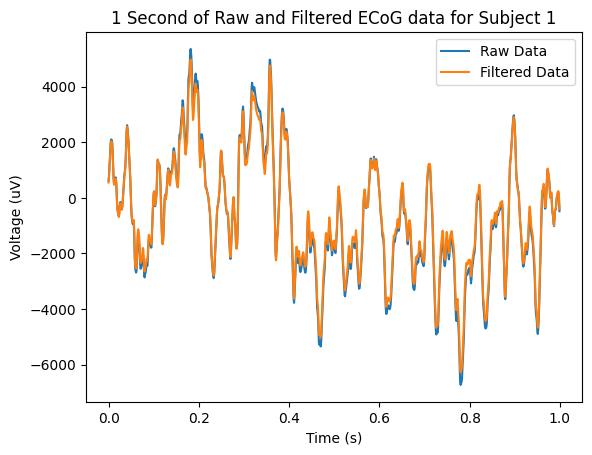

In [ ]:
filtered_1_ecog = filter_data(subject_1_ecog)
time = np.linspace(0,300000/1000,300000)
plt.plot(time[0:1000], subject_1_ecog[0:1000,0], label = 'Raw Data')
plt.plot(time[0:1000], filtered_1_ecog[0:1000,0], label = 'Filtered Data')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (uV)')
plt.title('1 Second of Raw and Filtered ECoG data for Subject 1')
plt.legend()
plt.show()

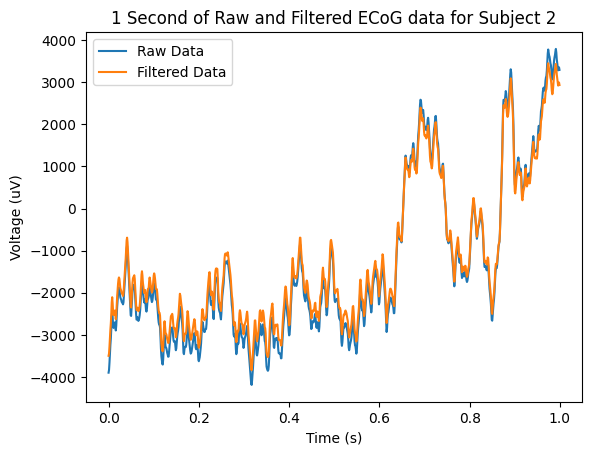

In [ ]:
filtered_2_ecog = filter_data(subject_2_ecog)
time = np.linspace(0,300000/1000,300000)
plt.plot(time[0:1000], subject_2_ecog[0:1000,0], label = 'Raw Data')
plt.plot(time[0:1000], filtered_2_ecog[0:1000,0], label = 'Filtered Data')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (uV)')
plt.title('1 Second of Raw and Filtered ECoG data for Subject 2')
plt.legend()
plt.show()

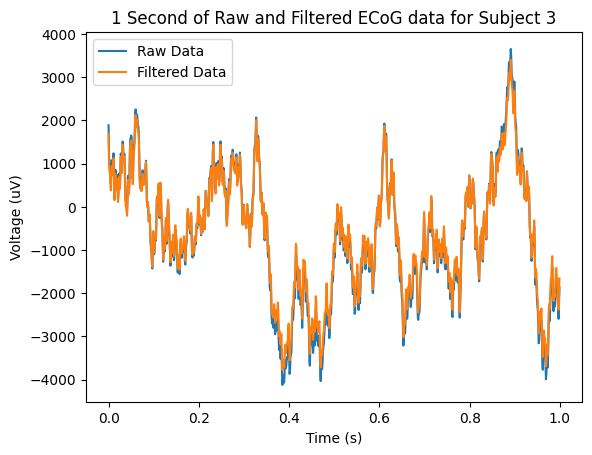

In [ ]:
filtered_3_ecog = filter_data(subject_3_ecog)
time = np.linspace(0,300000/1000,300000)
plt.plot(time[0:1000], subject_3_ecog[0:1000,0], label = 'Raw Data')
plt.plot(time[0:1000], filtered_3_ecog[0:1000,0], label = 'Filtered Data')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (uV)')
plt.title('1 Second of Raw and Filtered ECoG data for Subject 3')
plt.legend()
plt.show()

An FIR filter with order 49 and cutoff frequencies of [1, 400] was applied to the data. The training and prediction pipeline was run for different filter parameters, and the best results were given by these paramters, which do not heavily filter the signal.

# 2. Calculating Features (12 points)

Here you will complete the `get_windowed_feats` and `get_features` functions. 

## 1. 
We will calculate features across sliding time windows. if we use a suggested window length of 100ms with a 50ms window overlap, how many feature windows, $M$, will we have if we computed features using all the data in a given subject? Feel free to re-use code from previous homeworks. 

In [ ]:
def num_windows(x, fs,winLen, winDisp):
  xLen = len(x)
  winLen_vals = winLen * fs
  winDisp_vals =winDisp * fs
  return int((xLen - winLen_vals) / winDisp_vals ) +1

def MovingWinFeats(x, fs, winLen, winDisp, featFn):
  xLen = len(x)
  #NumWins(fs, winLen, winDisp, x)
  numWins = num_windows(x, fs,winLen, winDisp)
  result = []
  wd_fs = winDisp*fs
  wl_fs = winLen*fs
  for i in range(numWins):
    finish = (xLen - 1) - wd_fs *i 
    start = finish - wl_fs
    win = x[int(start):int(finish)]
    result.append(featFn(win))
  result.reverse()
  return result


'''
def MovingWins(x, fs, winLen, winDisp):

  for i in range(num_windows(x,fs,winLen,winDisp)):
    x_signal = x[int(winDisp*i*fs) : int(winDisp*i*fs + winLen*fs)]
    #values.append(featFn(x_signal))
    windows[i,:] = x_signal
  return np.transpose(windows)
'''

'\ndef MovingWins(x, fs, winLen, winDisp):\n\n  for i in range(num_windows(x,fs,winLen,winDisp)):\n    x_signal = x[int(winDisp*i*fs) : int(winDisp*i*fs + winLen*fs)]\n    #values.append(featFn(x_signal))\n    windows[i,:] = x_signal\n  return np.transpose(windows)\n'

In [ ]:
print(num_windows(filtered_1_ecog, 1000, 0.1, 0.05))

5999


We will have 5999 feature windows

## 2.
Now complete the `get_features` function. Please create **4 or more** different features to calculate for each channel in each time window. Features may include the average time-domain voltage, or the average frequency-domain magnitude in consecutive 15Hz frequency bands, bandpower of relevant frequency bands, etc...

In [ ]:
def get_features(filtered_window, fs=1000):
  """
    Write a function that calculates features for a given filtered window. 
    Feel free to use features you have seen before in this class, features that
    have been used in the literature, or design your own!
    Input: 
      filtered_window (window_samples x channels): the window of the filtered ecog signal 
      fs: sampling rate
    Output:
      features (channels x num_features): the features calculated on each channel for the window
  """
  number_of_features = 5
  channels = filtered_window.shape[1]
  features = np.zeros((channels, number_of_features))

  #filter_1 = sig.firwin(50, [1, 60], fs = fs, pass_zero = 'bandpass')
  #filter_2 = sig.firwin(50, [60, 100], fs = fs, pass_zero = 'bandpass')
  #filter_3 = sig.firwin(50, [100, 300], fs = fs, pass_zero = 'bandpass')
  #filter_4 = sig.firwin(50, [300, 499], fs = fs, pass_zero = 'bandpass')
  #filt_sig_1 = sig.filtfilt(filter_1, [1], filtered_window, padtype = None, axis = 1)
  #filt_sig_2 = sig.filtfilt(filter_2, [1], filtered_window, padtype = None, axis = 1)
  #filt_sig_3 = sig.filtfilt(filter_3, [1], filtered_window, padtype = None, axis = 1)
  #filt_sig_4 = sig.filtfilt(filter_4, [1], filtered_window, padtype = None, axis = 1)

  for i in range(channels):
    signal = filtered_window[:,i]
    ll = np.sum(np.absolute(np.ediff1d(signal)))
    area = np.sum(np.abs(signal))
    energy = np.sum(np.square(signal))
    
    mean = np.mean(signal)
    val = []
    for j in range(len(signal)-1):
      above = (signal[j] - mean > 0) and (signal[j+1] - mean < 0)
      below = (signal[j] - mean < 0) and (signal[j+1] - mean > 0)
      val.append(above or below)
    z_cross = np.sum(val)

    #filt_feat_1 = np.sum(np.square(filt_sig_1[i,:]))

    #filt_feat_2 = np.sum(np.square(filt_sig_2[i,:]))

    #filt_feat_3 = np.sum(np.square(filt_sig_3[i,:]))

    #filt_feat_4 = np.sum(np.square(filt_sig_4[i,:]))

    features[i,0] = ll
    features[i,1] = area
    features[i,2] = energy
    features[i,3] = z_cross
    features[i,4] = mean
    #features[i,4] = filt_feat_1
    #features[i,5] = filt_feat_2
    #features[i,6] = filt_feat_3
    #features[i,7] = filt_feat_4
  return features


5 features are used: line length, area, energy, zero-crossings, and mean signal.

## 3.
Now finish the `get_windowed_feats` function by putting the `filter_data` and `get_features` functions together to return a feature vector for each time window.

In [ ]:
def get_windowed_feats(raw_ecog, fs, window_length, window_overlap):
  """
    Write a function which processes data through the steps of filtering and
    feature calculation and returns features. Points will be awarded for completing
    each step appropriately (note that if one of the functions you call within this script
    returns a bad output, you won't be double penalized). Note that you will need
    to run the filter_data and get_features functions within this function. 

    Inputs:
      raw_eeg (samples x channels): the raw signal
      fs: the sampling rate (1000 for this dataset)
      window_length: the window's length
      window_overlap: the window's overlap
    Output: 
      all_feats (num_windows x (channels x features)): the features for each channel for each time window
        note that this is a 2D array. 
  """
  number_of_features = 5
  filtered_data = filter_data(raw_ecog)
  channels = filtered_data.shape[1]
  number_of_windows = num_windows(filtered_data, fs, window_length, window_overlap)
  all_feats = np.zeros((number_of_windows, channels*number_of_features))
  for j in range(number_of_windows):
    current_window = filtered_data[int(window_overlap*j*fs) : int(window_overlap*j*fs + window_length*fs),:]
    feats = get_features(current_window)
    all_feats[j,:] = feats.flatten()
  return all_feats


# 3. Creating the Response Matrix (6 points)
In this section, you will develop code for your *create_R_matrix* function

## 1.
For our set of 62 channels in subject 1, what would the dimensions of the R matrix be if we calculated 6 di
erent feature types per channel, and N = 3 time bins where the number of total time bins M is the number you calculated in 2.1? (1pt)

In [ ]:
cols = 6*62*3+1
rows = 5999
print('Rows: {}, Cols: {}'.format(rows,cols))


Rows: 5999, Cols: 1117


This is assuming that we have padded so that we can use the first two time bins

## 2. 
We do not have feature data to fill out the first N-1 data rows in the R matrix that will be used to predict the first N-1 finger angles. One way to work around this is to append a copy of the first N-1 rows of your feature matrix to the beginning of your feature matrix before calculating R. Make this adjustment in `create_R_matrix`, then compute the response matrix R. You can test whether your function is running correctly by running `create_R_matrix` with data from `testRfunction.pkl` using 3 windows and verifying that the quantity `np.mean(R)` is 25.4668 (5 points).

In [ ]:
R_test_path = Path('/content/drive/MyDrive/testRfunction.pkl')
with open(R_test_path, 'rb') as f:
  R_test = pickle.load(f)

In [ ]:
def create_R_matrix(features, N_wind):
  """ 
  Write a function to calculate the R matrix

  Input:
    features (samples (number of windows in the signal) x channels x features): 
      the features you calculated using get_windowed_feats
    N_wind: number of windows to use in the R matrix

  Output:
    R (samples x (N_wind*channels*features))
  """
  m = features.shape[0]
  n = features.shape[1]
  R = np.zeros((m, n*N_wind))
  first_rows = features[0:N_wind-1, :]
  features = np.insert(features, 0, first_rows, axis = 0)
  preceding = N_wind-1
  for i in range(0,m):
    features_window = np.transpose(features[i:i+N_wind,:]).flatten()
    R[i,:] = features_window
  R = np.insert(R, 0, 1, axis = 1)
  return R


In [ ]:
print(np.mean(create_R_matrix(R_test, 3)))

25.46678519830894


# 4. ML Training and Testing (10 points)
Here we will use the optimal linear decoder framework to predict finger angles, and additionally you will use one or more classifiers of your own choosing to make the prediction.

## 1. 

Calculate the linear filter $\text{f}$ as defined above for all 5 finger angles using features calculated from your training data. You will have to first down-sample the finger flexion data so that your feature matrix, $\textbf{R}$, and your flexion data have the same number of time windows.

You will likely find [np.matmul](https://numpy.org/doc/stable/reference/generated/numpy.matmul.html), and [np.linalg.inv](https://numpy.org/doc/stable/reference/generated/numpy.linalg.inv.html) to be useful. 

In [ ]:
down_sampled_glove_train_1 = glove_train_1[50::50]
down_sampled_glove_test_1 = glove_test_1[50::50]

down_sampled_glove_train_2 = glove_train_2[50::50]
down_sampled_glove_test_2 = glove_test_2[50::50]

down_sampled_glove_train_3 = glove_train_3[50::50]
down_sampled_glove_test_3 = glove_test_3[50::50]


feats_1 = get_windowed_feats(ecog_train_1, 1000, 0.1, 0.05)
feats_2 = get_windowed_feats(ecog_train_2, 1000, 0.1, 0.05)
feats_3 = get_windowed_feats(ecog_train_3, 1000, 0.1, 0.05)

n = 3
R_1 = create_R_matrix(feats_1, n)
R_2 = create_R_matrix(feats_2, n)
R_3 = create_R_matrix(feats_3, n)


f_1 = np.linalg.inv(R_1.T@R_1)@(R_1.T@down_sampled_glove_train_1)
f_2 = np.linalg.inv(R_2.T@R_2)@(R_2.T@down_sampled_glove_train_2)
f_3 = np.linalg.inv(R_3.T@R_3)@(R_3.T@down_sampled_glove_train_3)

feats_test_1 = get_windowed_feats(ecog_test_1, 1000, 0.1, 0.05)
R_1_test = create_R_matrix(feats_test_1, n)

feats_test_2 = get_windowed_feats(ecog_test_2, 1000, 0.1, 0.05)
R_2_test = create_R_matrix(feats_test_2, n)

feats_test_3 = get_windowed_feats(ecog_test_3, 1000, 0.1, 0.05)
R_3_test = create_R_matrix(feats_test_3, n)

In [ ]:
print('Subject 1 f size: {}, Subject 2 f size: {}, Subject 3 f size: {}'.format(f_1.shape, f_2.shape, f_3.shape))

Subject 1 f size: (916, 5), Subject 2 f size: (691, 5), Subject 3 f size: (961, 5)


## 2.
Try one other machine learning classifier using your features and finger angle labels. Look back through previous homeworks to get some ideas

In [ ]:
from sklearn.svm import SVR

scores = np.zeros((5,3))

svr_1 = SVR(kernel = 'rbf', epsilon= 0.5, C = 3)
svr_2 = SVR(kernel = 'rbf', epsilon = 0.5, C = 1)
svr_3 = SVR(kernel = 'rbf', epsilon = 0.7, C = 1)

svr_pred_1 = np.zeros((len(down_sampled_glove_test_1[:,1]),5))
svr_pred_2 = np.zeros((len(down_sampled_glove_test_1[:,1]),5))
svr_pred_3 = np.zeros((len(down_sampled_glove_test_1[:,1]),5))

for i in range(5):
  svr_1.fit(feats_1,down_sampled_glove_train_1[:,i])
  svr_train_score = svr_1.score(feats_1,down_sampled_glove_train_1[:,i])
  svr_predict = svr_1.predict(feats_test_1)
  #svr_test_score = svr.score(feats_test_1,svr_predict)
  score = pearsonr(down_sampled_glove_test_1[:,i], svr_predict).statistic
  scores[i,0] = score
  svr_pred_1[:,i] = svr_predict

for i in range(5):
  svr_2.fit(feats_2,down_sampled_glove_train_2[:,i])
  svr_train_score = svr_2.score(feats_2,down_sampled_glove_train_2[:,i])
  svr_predict = svr_2.predict(feats_test_2)
  #svr_test_score = svr.score(feats_test_2,svr_predict)
  score = pearsonr(down_sampled_glove_test_2[:,i], svr_predict).statistic
  scores[i,1] = score
  svr_pred_2[:,i] = svr_predict

for i in range(5):
  svr_3.fit(feats_3,down_sampled_glove_train_3[:,i])
  svr_train_score = svr_3.score(feats_3,down_sampled_glove_train_3[:,i])
  svr_predict = svr_3.predict(feats_test_3)
  #svr_test_score = svr.score(feats_test_3,svr_predict)
  score = pearsonr(down_sampled_glove_test_3[:,i], svr_predict).statistic
  scores[i,2] = score
  svr_pred_3[:,i] = svr_predict

print('Correlation Scores for the test finger angle predictions using the SVR \
model. The rows represent fingers 1-5 and the columns represent \
subjects 1-3.')
print(scores)
print('The mean correlation score across fingers and subjects for the SVR model:')
print(np.mean(scores))


Correlation Scores for the test finger angle predictions using the SVR model. The rows represent fingers 1-5 and the columns represent subjects 1-3.
[[ 0.0472824   0.07928106  0.24981453]
 [ 0.06492863  0.0467599   0.1456174 ]
 [-0.01968502  0.0466544   0.16260484]
 [ 0.03145522  0.15982457  0.29290477]
 [ 0.1191049   0.04242509  0.20153522]]
The mean correlation score across fingers and subjects for the SVR model:
0.11136719387335889


In [ ]:
print('These results are for predictions using the SVR model.')

true_finger_vals = np.zeros(len(down_sampled_glove_test_1[:,0][0::80])-1)
svr_predicted_finger_vals = np.zeros(len(down_sampled_glove_test_1[:,0][0::80])-1)

for j in range(len(down_sampled_glove_test_1[:,0][0::80])-1):
  trial_data = np.zeros((5, len(down_sampled_glove_test_1[:,0][j*80:j*80+40])))
  trial_data[0,:] = down_sampled_glove_test_1[:,0][j*80:j*80+40]
  trial_data[1,:] = down_sampled_glove_test_1[:,1][j*80:j*80+40]
  trial_data[2,:] = down_sampled_glove_test_1[:,2][j*80:j*80+40]
  trial_data[3,:] = down_sampled_glove_test_1[:,3][j*80:j*80+40]
  trial_data[4,:] = down_sampled_glove_test_1[:,4][j*80:j*80+40]
  max_vals = np.nanmax(trial_data, axis=1)
  finger_true = np.argmax(max_vals)
  true_finger_vals[j] = finger_true

  svr_pred_data = np.zeros((5, len(down_sampled_glove_test_1[:,0][j*80:j*80+40])))
  svr_pred_data[0,:] = svr_pred_1[:,0][j*80:j*80+40]
  svr_pred_data[1,:] = svr_pred_1[:,1][j*80:j*80+40]
  svr_pred_data[2,:] = svr_pred_1[:,2][j*80:j*80+40]
  svr_pred_data[3,:] = svr_pred_1[:,3][j*80:j*80+40]
  svr_pred_data[4,:] = svr_pred_1[:,4][j*80:j*80+40]
  max_predicted_vals = np.nanmax(svr_pred_data, axis=1)
  finger_predict = np.argmax(max_predicted_vals)
  svr_predicted_finger_vals[j] = finger_predict

  #plt.plot(trial_data[0,:])
  #plt.plot(trial_data[1,:])
  #plt.plot(trial_data[2,:])
  #plt.plot(trial_data[3,:])
  #plt.plot(trial_data[4,:])
  #plt.show()

print('True finger movements for subject 1, with 0 starting index: {}'.format(true_finger_vals))
print('SVR Predicted finger movements for subject 1, with 0 starting index: {}'.format(svr_predicted_finger_vals))
print('The accuracy of the SVR model for predicting which finger moved across all trials for subject 1 is: {}'.format(np.sum(true_finger_vals == svr_predicted_finger_vals)/len(true_finger_vals)))

# Subject 2

true_finger_vals_2 = np.zeros(len(down_sampled_glove_test_2[:,0][0::80])-1)
svr_predicted_finger_vals_2 = np.zeros(len(down_sampled_glove_test_2[:,0][0::80])-1)

for j in range(len(down_sampled_glove_test_2[:,0][0::80])-1):
  trial_data = np.zeros((5, len(down_sampled_glove_test_2[:,0][j*80:j*80+40])))
  trial_data[0,:] = down_sampled_glove_test_2[:,0][j*80:j*80+40]
  trial_data[1,:] = down_sampled_glove_test_2[:,1][j*80:j*80+40]
  trial_data[2,:] = down_sampled_glove_test_2[:,2][j*80:j*80+40]
  trial_data[3,:] = down_sampled_glove_test_2[:,3][j*80:j*80+40]
  trial_data[4,:] = down_sampled_glove_test_2[:,4][j*80:j*80+40]
  max_vals = np.nanmax(trial_data, axis=1)
  finger_true = np.argmax(max_vals)
  true_finger_vals_2[j] = finger_true

  svr_pred_data = np.zeros((5, len(down_sampled_glove_test_2[:,0][j*80:j*80+40])))
  svr_pred_data[0,:] = svr_pred_2[:,0][j*80:j*80+40]
  svr_pred_data[1,:] = svr_pred_2[:,1][j*80:j*80+40]
  svr_pred_data[2,:] = svr_pred_2[:,2][j*80:j*80+40]
  svr_pred_data[3,:] = svr_pred_2[:,3][j*80:j*80+40]
  svr_pred_data[4,:] = svr_pred_2[:,4][j*80:j*80+40]
  max_predicted_vals = np.nanmax(svr_pred_data, axis=1)
  finger_predict = np.argmax(max_predicted_vals)
  svr_predicted_finger_vals_2[j] = finger_predict

  #plt.plot(trial_data[0,:])
  #plt.plot(trial_data[1,:])
  #plt.plot(trial_data[2,:])
  #plt.plot(trial_data[3,:])
  #plt.plot(trial_data[4,:])
  #plt.show()

print('True finger movements for subject 2, with 0 starting index: {}'.format(true_finger_vals_2))
print('SVR Predicted finger movements for subject 2, with 0 starting index: {}'.format(svr_predicted_finger_vals_2))
print('The accuracy of the SVR model for predicting which finger moved across all trials for subject 2 is: {}'.format(np.sum(true_finger_vals_2 == svr_predicted_finger_vals_2)/len(true_finger_vals_2)))

# Subject 3

true_finger_vals_3 = np.zeros(len(down_sampled_glove_test_3[:,0][0::80])-1)
svr_predicted_finger_vals_3 = np.zeros(len(down_sampled_glove_test_3[:,0][0::80])-1)

for j in range(len(down_sampled_glove_test_3[:,0][0::80])-1):
  trial_data = np.zeros((5, len(down_sampled_glove_test_3[:,0][j*80:j*80+40])))
  trial_data[0,:] = down_sampled_glove_test_3[:,0][j*80:j*80+40]
  trial_data[1,:] = down_sampled_glove_test_3[:,1][j*80:j*80+40]
  trial_data[2,:] = down_sampled_glove_test_3[:,2][j*80:j*80+40]
  trial_data[3,:] = down_sampled_glove_test_3[:,3][j*80:j*80+40]
  trial_data[4,:] = down_sampled_glove_test_3[:,4][j*80:j*80+40]
  max_vals = np.nanmax(trial_data, axis=1)
  finger_true = np.argmax(max_vals)
  true_finger_vals_3[j] = finger_true

  svr_pred_data = np.zeros((5, len(down_sampled_glove_test_3[:,0][j*80:j*80+40])))
  svr_pred_data[0,:] = svr_pred_3[:,0][j*80:j*80+40]
  svr_pred_data[1,:] = svr_pred_3[:,1][j*80:j*80+40]
  svr_pred_data[2,:] = svr_pred_3[:,2][j*80:j*80+40]
  svr_pred_data[3,:] = svr_pred_3[:,3][j*80:j*80+40]
  svr_pred_data[4,:] = svr_pred_3[:,4][j*80:j*80+40]
  max_predicted_vals = np.nanmax(svr_pred_data, axis=1)
  finger_predict = np.argmax(max_predicted_vals)
  svr_predicted_finger_vals_3[j] = finger_predict

  #plt.plot(trial_data[0,:])
  #plt.plot(trial_data[1,:])
  #plt.plot(trial_data[2,:])
  #plt.plot(trial_data[3,:])
  #plt.plot(trial_data[4,:])
  #plt.show()

print('True finger movements for subject 2, with 0 starting index: {}'.format(true_finger_vals_3))
print('Predicted finger movements for subject 2, with 0 starting index: {}'.format(svr_predicted_finger_vals_3))
print('The accuracy of the model for predicting which finger moved across all trials for subject 3 is: {}'.format(np.sum(true_finger_vals_3 == svr_predicted_finger_vals_3)/len(true_finger_vals_3)))


These results are for predictions using the SVR model.
True finger movements for subject 1, with 0 starting index: [3. 2. 4. 1. 0. 4. 1. 0. 3. 0. 2. 3. 0. 3. 3. 1. 3. 0. 3. 1. 0. 0.]
SVR Predicted finger movements for subject 1, with 0 starting index: [2. 4. 4. 2. 1. 4. 1. 2. 2. 4. 4. 2. 4. 4. 2. 1. 0. 2. 0. 0. 4. 2.]
The accuracy of the SVR model for predicting which finger moved across all trials for subject 1 is: 0.18181818181818182
True finger movements for subject 2, with 0 starting index: [4. 0. 2. 2. 1. 4. 4. 2. 2. 0. 1. 1. 2. 4. 3. 4. 1. 3. 1. 0. 4. 3.]
SVR Predicted finger movements for subject 2, with 0 starting index: [2. 2. 2. 1. 2. 3. 2. 2. 2. 2. 2. 2. 2. 3. 2. 2. 2. 3. 2. 2. 3. 2.]
The accuracy of the SVR model for predicting which finger moved across all trials for subject 2 is: 0.22727272727272727
True finger movements for subject 2, with 0 starting index: [3. 2. 0. 2. 3. 4. 4. 3. 0. 4. 4. 4. 0. 1. 3. 2. 2. 2. 3. 3. 0. 2.]
Predicted finger movements for subject 2, with 

The ML model implemented here is SVR (support vector regression). This approach is similar to linear regression, but uses support vector machines. Parameter epsilon refers to the width of the support vectors and C refers to the tolerance of points outside the epsilon margin. This model makes predictions of the finger angles using the features and the glove data. The predictions are then compared to the test glove angles for correlation scores. The mean correlation score across fingers and subjects is 0.11. In order to predict the finger that was flexed, the predicted finger angles are compared to the true finger angles for each trial. Only the first 2 seconds of each trial are considered, since the subject flexes the finger during the first 2 seconds. The predicted finger for each trial is taken as the finger that has the largest predicted angle value. The accuracy is then reported as the percentage of trials for which the model predicted the correct finger.

## 3. 
Produce predictions on the testing set for each finger angle. Calculate the correlation coefficient between the predicted and test finger angles for each finger separately. Report you correlations here using the lineare filter, and when using the other classifier(s) that you tried. 

You will find  [pearsonr](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html) to be helpful and already imported. 

In [ ]:
pred_1 = R_1_test @ f_1

pred_2 = R_2_test @ f_2

pred_3 = R_3_test @ f_3

correlation_scores = np.zeros((5,3))

for i in range(5):
  correlation_scores[i,0] = pearsonr(down_sampled_glove_test_1[:,i], pred_1[:,i]).statistic
  correlation_scores[i,1] = pearsonr(down_sampled_glove_test_2[:,i], pred_2[:,i]).statistic
  correlation_scores[i,2] = pearsonr(down_sampled_glove_test_3[:,i], pred_3[:,i]).statistic

print('Correlation Scores for the test finger angle predictions using the optimal \
linear decoder model. The rows represent fingers 1-5 and the columns represent \
subjects 1-3.')
print(correlation_scores)
print('The mean correlation score across fingers and subjects for the optimal linear decoder model:')
print(np.mean(correlation_scores))


Correlation Scores for the test finger angle predictions using the optimal linear decoder model. The rows represent fingers 1-5 and the columns represent subjects 1-3.
[[0.38405292 0.33970359 0.48268539]
 [0.3092349  0.20134636 0.2696707 ]
 [0.13295664 0.15606399 0.38456381]
 [0.40083903 0.24299662 0.45111635]
 [0.07935389 0.1629709  0.35760237]]
The mean correlation score across fingers and subjects for the optimal linear decoder model:
0.2903438303738563


In [ ]:
print('These results are for predictions using the optimal linear decoder model.')

true_finger_vals = np.zeros(len(down_sampled_glove_test_1[:,0][0::80])-1)
predicted_finger_vals = np.zeros(len(down_sampled_glove_test_1[:,0][0::80])-1)

for j in range(len(down_sampled_glove_test_1[:,0][0::80])-1):
  trial_data = np.zeros((5, len(down_sampled_glove_test_1[:,0][j*80:j*80+40])))
  trial_data[0,:] = down_sampled_glove_test_1[:,0][j*80:j*80+40]
  trial_data[1,:] = down_sampled_glove_test_1[:,1][j*80:j*80+40]
  trial_data[2,:] = down_sampled_glove_test_1[:,2][j*80:j*80+40]
  trial_data[3,:] = down_sampled_glove_test_1[:,3][j*80:j*80+40]
  trial_data[4,:] = down_sampled_glove_test_1[:,4][j*80:j*80+40]
  max_vals = np.nanmax(trial_data, axis=1)
  finger_true = np.argmax(max_vals)
  true_finger_vals[j] = finger_true

  pred_data = np.zeros((5, len(down_sampled_glove_test_1[:,0][j*80:j*80+40])))
  pred_data[0,:] = pred_1[:,0][j*80:j*80+40]
  pred_data[1,:] = pred_1[:,1][j*80:j*80+40]
  pred_data[2,:] = pred_1[:,2][j*80:j*80+40]
  pred_data[3,:] = pred_1[:,3][j*80:j*80+40]
  pred_data[4,:] = pred_1[:,4][j*80:j*80+40]
  max_predicted_vals = np.nanmax(pred_data, axis=1)
  finger_predict = np.argmax(max_predicted_vals)
  predicted_finger_vals[j] = finger_predict

  #plt.plot(trial_data[0,:])
  #plt.plot(trial_data[1,:])
  #plt.plot(trial_data[2,:])
  #plt.plot(trial_data[3,:])
  #plt.plot(trial_data[4,:])
  #plt.show()

print('True finger movements for subject 1, with 0 starting index: {}'.format(true_finger_vals))
print('Predicted finger movements for subject 1, with 0 starting index: {}'.format(predicted_finger_vals))
print('The accuracy of the model for predicting which finger moved across all trials for subject 1 is: {}'.format(np.sum(true_finger_vals == predicted_finger_vals)/len(true_finger_vals)))

# Subject 2

true_finger_vals_2 = np.zeros(len(down_sampled_glove_test_2[:,0][0::80])-1)
predicted_finger_vals_2 = np.zeros(len(down_sampled_glove_test_2[:,0][0::80])-1)

for j in range(len(down_sampled_glove_test_2[:,0][0::80])-1):
  trial_data = np.zeros((5, len(down_sampled_glove_test_2[:,0][j*80:j*80+40])))
  trial_data[0,:] = down_sampled_glove_test_2[:,0][j*80:j*80+40]
  trial_data[1,:] = down_sampled_glove_test_2[:,1][j*80:j*80+40]
  trial_data[2,:] = down_sampled_glove_test_2[:,2][j*80:j*80+40]
  trial_data[3,:] = down_sampled_glove_test_2[:,3][j*80:j*80+40]
  trial_data[4,:] = down_sampled_glove_test_2[:,4][j*80:j*80+40]
  max_vals = np.nanmax(trial_data, axis=1)
  finger_true = np.argmax(max_vals)
  true_finger_vals_2[j] = finger_true

  pred_data = np.zeros((5, len(down_sampled_glove_test_2[:,0][j*80:j*80+40])))
  pred_data[0,:] = pred_2[:,0][j*80:j*80+40]
  pred_data[1,:] = pred_2[:,1][j*80:j*80+40]
  pred_data[2,:] = pred_2[:,2][j*80:j*80+40]
  pred_data[3,:] = pred_2[:,3][j*80:j*80+40]
  pred_data[4,:] = pred_2[:,4][j*80:j*80+40]
  max_predicted_vals = np.nanmax(pred_data, axis=1)
  finger_predict = np.argmax(max_predicted_vals)
  predicted_finger_vals_2[j] = finger_predict

  #plt.plot(trial_data[0,:])
  #plt.plot(trial_data[1,:])
  #plt.plot(trial_data[2,:])
  #plt.plot(trial_data[3,:])
  #plt.plot(trial_data[4,:])
  #plt.show()

print('True finger movements for subject 2, with 0 starting index: {}'.format(true_finger_vals_2))
print('Predicted finger movements for subject 2, with 0 starting index: {}'.format(predicted_finger_vals_2))
print('The accuracy of the model for predicting which finger moved across all trials for subject 2 is: {}'.format(np.sum(true_finger_vals_2 == predicted_finger_vals_2)/len(true_finger_vals_2)))

# Subject 3

true_finger_vals_3 = np.zeros(len(down_sampled_glove_test_3[:,0][0::80])-1)
predicted_finger_vals_3 = np.zeros(len(down_sampled_glove_test_3[:,0][0::80])-1)

for j in range(len(down_sampled_glove_test_3[:,0][0::80])-1):
  trial_data = np.zeros((5, len(down_sampled_glove_test_3[:,0][j*80:j*80+40])))
  trial_data[0,:] = down_sampled_glove_test_3[:,0][j*80:j*80+40]
  trial_data[1,:] = down_sampled_glove_test_3[:,1][j*80:j*80+40]
  trial_data[2,:] = down_sampled_glove_test_3[:,2][j*80:j*80+40]
  trial_data[3,:] = down_sampled_glove_test_3[:,3][j*80:j*80+40]
  trial_data[4,:] = down_sampled_glove_test_3[:,4][j*80:j*80+40]
  max_vals = np.nanmax(trial_data, axis=1)
  finger_true = np.argmax(max_vals)
  true_finger_vals_3[j] = finger_true

  pred_data = np.zeros((5, len(down_sampled_glove_test_3[:,0][j*80:j*80+40])))
  pred_data[0,:] = pred_3[:,0][j*80:j*80+40]
  pred_data[1,:] = pred_3[:,1][j*80:j*80+40]
  pred_data[2,:] = pred_3[:,2][j*80:j*80+40]
  pred_data[3,:] = pred_3[:,3][j*80:j*80+40]
  pred_data[4,:] = pred_3[:,4][j*80:j*80+40]
  max_predicted_vals = np.nanmax(pred_data, axis=1)
  finger_predict = np.argmax(max_predicted_vals)
  predicted_finger_vals_3[j] = finger_predict

  #plt.plot(trial_data[0,:])
  #plt.plot(trial_data[1,:])
  #plt.plot(trial_data[2,:])
  #plt.plot(trial_data[3,:])
  #plt.plot(trial_data[4,:])
  #plt.show()

print('True finger movements for subject 3, with 0 starting index: {}'.format(true_finger_vals_3))
print('Predicted finger movements for subject 3, with 0 starting index: {}'.format(predicted_finger_vals_3))
print('The accuracy of the model for predicting which finger moved across all trials for subject 3 is: {}'.format(np.sum(true_finger_vals_3 == predicted_finger_vals_3)/len(true_finger_vals_3)))


These results are for predictions using the optimal linear decoder model.
True finger movements for subject 1, with 0 starting index: [3. 2. 4. 1. 0. 4. 1. 0. 3. 0. 2. 3. 0. 3. 3. 1. 3. 0. 3. 1. 0. 0.]
Predicted finger movements for subject 1, with 0 starting index: [4. 2. 2. 1. 4. 4. 1. 2. 2. 0. 2. 2. 0. 3. 2. 2. 4. 2. 2. 1. 4. 2.]
The accuracy of the model for predicting which finger moved across all trials for subject 1 is: 0.4090909090909091
True finger movements for subject 2, with 0 starting index: [4. 0. 2. 2. 1. 4. 4. 2. 2. 0. 1. 1. 2. 4. 3. 4. 1. 3. 1. 0. 4. 3.]
Predicted finger movements for subject 2, with 0 starting index: [1. 2. 3. 2. 2. 3. 3. 3. 2. 1. 2. 1. 2. 3. 2. 2. 2. 3. 2. 2. 3. 3.]
The accuracy of the model for predicting which finger moved across all trials for subject 2 is: 0.2727272727272727
True finger movements for subject 3, with 0 starting index: [3. 2. 0. 2. 3. 4. 4. 3. 0. 4. 4. 4. 0. 1. 3. 2. 2. 2. 3. 3. 0. 2.]
Predicted finger movements for subject 3, with

The approach here to predict the finger that is flexed for eah trial is the same as that mentioned above for the SVR model.

In [ ]:
!jupyter nbconvert --to html viraj_sampat_Final_Project_Part_1.ipynb

[NbConvertApp] Converting notebook viraj_sampat_Final_Project_Part_1.ipynb to html
[NbConvertApp] Writing 1059729 bytes to viraj_sampat_Final_Project_Part_1.html
